### LSTM -RBF serial

* Uses physics in the input data (Calculate the wing Cl and Cd from the airfoil - model/databse)
* Only use LSTM
* Currently uses airfoil polars from the database 
* Only wing with single airfoil section throughout

* Specific to emagic one geometry - works for both wing and canard

### Working -  

In [1]:
import os
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
# from torchviz import make_dot
from scipy.fftpack import fft, ifft
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt

import joblib

In [2]:
import datetime
date = datetime.date.today()

In [3]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# Downsampling using average pooling
"""
Downsample the input array to 35 elements using interpolation.
"""

def downsample_to_35(input_array):
    input_tensor = torch.tensor(input_array, dtype=torch.float32)
    
    # Reshape the input to be 1D (if it's not already)
    if input_tensor.dim() == 1:
        input_tensor = input_tensor.unsqueeze(0).unsqueeze(0)  # Shape (1, 1, original_length)
    elif input_tensor.dim() == 2:
        input_tensor = input_tensor.unsqueeze(0)  # Shape (1, original_channels, original_length)
    
    # Perform interpolation to downsample to 35 elements
    downsampled_tensor = F.interpolate(input_tensor, size=35, mode='linear', align_corners=True)
    
    # Remove the unnecessary dimensions to return a 1D tensor
    downsampled_array = downsampled_tensor.squeeze().numpy()
    
    return downsampled_array

"""
Create the dataset
Arange the input data in columns [x, y, alpha (AOA), Re, M]
"""
def organize_data(x_f, y_f, alphas):

    Elements = []

    # Loop through the polars
    for n_file in range(len(x_f)):
        x_temp = x_f[n_file]
        y_temp = y_f[n_file]
        alpha_temp = alphas[n_file]
        
        for j in range(len(alpha_temp)):
            batch = []
            # Loop through the coodrinates
            for i in range(len(x_temp)-1):
                element = np.array([x_temp[i], y_temp[i], x_temp[i+1], y_temp[i+1], alpha_temp[j]])
                batch.append(element)
            batch = np.array(batch)
            batch = batch.flatten()
            Elements.append(batch)

    Elements = np.array(Elements)

    return Elements

In [5]:
"""
Element Spatial Convolutional Neural Network model
Number of convolutional layers - 4
Number of fully connected layers - 2
"""

# Model for lift coefficient
class ESCNN_Cl(nn.Module):
    def __init__(self):
        super(ESCNN_Cl, self).__init__()
        
        # Conv1: Assume 1D Convolution
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=200, kernel_size=5, stride=5)
        self.relu1 = nn.ReLU()

        #conv2
        self.conv2 = nn.Conv1d(in_channels=200, out_channels=200, kernel_size=1)
        self.relu2 = nn.ReLU()

        # Conv3
        self.conv3 = nn.Conv1d(in_channels=200, out_channels=100, kernel_size=1)
        self.relu3 = nn.ReLU()
        
        # Conv4
        self.conv4 = nn.Conv1d(in_channels=100, out_channels=1, kernel_size=5, padding=2)
        self.relu4 = nn.ReLU()
        
        # Final fully connected layer to output scalar
        self.fc1 = nn.Linear(in_features=34, out_features=34)
        self.relu5 = nn.ReLU()

        self.fc2 = nn.Linear(in_features=34, out_features=1)
    
    def forward(self, x):
        # Reshape input if necessary, ensure it's in the shape (batch_size, channels, elements)
        x = x.view(-1, 1, 170)  # Reshape to (batch_size, channel=1, elements=170)
        
        x = self.conv1(x)  
        x = self.relu1(x)
        
        x = self.conv2(x)  
        x = self.relu2(x)

        x = self.conv3(x)  
        x = self.relu3(x)
        
        x = self.conv4(x)  
        x = self.relu4(x)
        
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)  
        x = self.relu5(x)

        x = self.fc2(x)
        
        return x


In [6]:
"""
Element Spatial Convolutional Neural Network model
Number of convolutional layers - 3
Number of fully connected layers - 2
"""

class ESCNN_Cd(nn.Module):
    def __init__(self):
        super(ESCNN_Cd, self).__init__()
        
        # Conv1: Assume 1D Convolution
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=200, kernel_size=5, stride=5)
        self.relu1 = nn.ReLU()

        #conv2
        self.conv2 = nn.Conv1d(in_channels=200, out_channels=200, kernel_size=1)
        self.relu2 = nn.ReLU()
        
        # Conv2
        self.conv3 = nn.Conv1d(in_channels=200, out_channels=1, kernel_size=5, padding=2)
        self.relu3 = nn.ReLU()
        
        # Final fully connected layer to output scalar
        self.fc1 = nn.Linear(in_features=34, out_features=34)
        self.relu4 = nn.ReLU()

        self.fc2 = nn.Linear(in_features=34, out_features=1)

        # Define learnable parameters for C_d0 and k
        self.Cd0 = nn.Parameter(torch.tensor(0.02))  # Initialized zero-lift drag coefficient
        self.k = nn.Parameter(torch.tensor(0.05))    # Initialized induced drag factor

    
    def forward(self, x):
        # Reshape input if necessary, ensure it's in the shape (batch_size, channels, elements)
        x = x.view(-1, 1, 170)  # Reshape to (batch_size, channel=1, elements=170)
        
        x = self.conv1(x)  
        x = self.relu1(x)
        
        x = self.conv2(x)  
        x = self.relu2(x)

        x = self.conv3(x)  
        x = self.relu3(x)
        
        
        x = torch.flatten(x, 1)
        
        x = self.fc1(x) 
        x = self.relu4(x)

        x = self.fc2(x)
        
        return x

In [7]:
# Initialize airfoil model (Use the saved trained model)

# Cl Model
class RBFLayer_cl(nn.Module):
    def __init__(self, in_features, out_features, centers=None):
        super(RBFLayer_cl, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Centers initialized using KMeans or passed explicitly
        if centers is None:
            self.centers = nn.Parameter(torch.Tensor(out_features, in_features))
            nn.init.uniform_(self.centers, -1, 1)  # Random if not initialized with KMeans
        else:
            self.centers = nn.Parameter(torch.Tensor(centers))  # Set centers from KMeans
        
        # Initialize the beta (width) parameter, positive constraint with softplus
        self.log_beta = nn.Parameter(torch.ones(out_features) * torch.log(torch.tensor(0.1)))

    @property
    def beta(self):
        # Ensures beta is positive using softplus
        return F.softplus(self.log_beta)
    
    def forward(self, input):
        # Compute distances between inputs and centers
        x = input.unsqueeze(1).expand(-1, self.out_features, self.in_features)
        c = self.centers.unsqueeze(0).expand(input.size(0), -1, -1)
        
        # Squared Euclidean distance
        distances = torch.sum((x - c) ** 2, dim=-1).to(device)
        
        # Apply Gaussian RBF
        return torch.exp(-self.beta.unsqueeze(0) * distances)

class RBFNet_cl(nn.Module):
    def __init__(self, input_size, rbf_units, output_size, centers=None):
        super(RBFNet_cl, self).__init__()
        self.rbf = RBFLayer_cl(input_size, rbf_units, centers)
        self.fc = nn.Linear(rbf_units, output_size)
        
        # Initialize weights for the linear layer
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, x):
        rbf_out = self.rbf(x)
        return self.fc(rbf_out)

# Cd Model
class RBFLayer_cd(nn.Module):
    def __init__(self, in_features, out_features, centers=None):
        super(RBFLayer_cd, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Centers initialized using KMeans or passed explicitly
        if centers is None:
            self.centers = nn.Parameter(torch.Tensor(out_features, in_features))
            nn.init.uniform_(self.centers, -1, 1)  # Random if not initialized with KMeans
        else:
            self.centers = nn.Parameter(torch.Tensor(centers))  # Set centers from KMeans
        
        # Initialize the beta (width) parameter, positive constraint with softplus
        self.log_beta = nn.Parameter(torch.ones(out_features) * torch.log(torch.tensor(18.2)))

    @property
    def beta(self):
        # Ensures beta is positive using softplus
        return F.softplus(self.log_beta)
    
    def forward(self, input):
        # Compute distances between inputs and centers
        x = input.unsqueeze(1).expand(-1, self.out_features, self.in_features)
        c = self.centers.unsqueeze(0).expand(input.size(0), -1, -1)
        
        # Squared Euclidean distance
        distances = torch.sum((x - c) ** 2, dim=-1).to(device)
        
        # Apply Gaussian RBF
        return torch.exp(-self.beta.unsqueeze(0) * distances)

class RBFNet_cd(nn.Module):
    def __init__(self, input_size, rbf_units, output_size, centers=None):
        super(RBFNet_cd, self).__init__()
        self.rbf = RBFLayer_cd(input_size, rbf_units, centers)
        self.fc = nn.Linear(rbf_units, output_size)
        
        # Initialize weights for the linear layer
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, x):
        rbf_out = self.rbf(x)
        return self.fc(rbf_out)
     


In [8]:
# Load the model weights
af_model_ESCNN_Cl = ESCNN_Cl()
af_model_ESCNN_Cl.load_state_dict(torch.load('/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/airfoil/2024-11-18_model_Cl_ESCNN_lr1e-05_e1500_rbf170_convL4.pth'))
af_model_ESCNN_Cl = af_model_ESCNN_Cl.to(device)
af_model_ESCNN_Cl.eval()

# Load the model weights
af_model_ESCNN_Cd = ESCNN_Cd()
af_model_ESCNN_Cd.load_state_dict(torch.load('/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/airfoil/2024-11-18_model_Cd_ESCNN_lr5e-05_e250_convL3.pth'))
af_model_ESCNN_Cd = af_model_ESCNN_Cd.to(device)
af_model_ESCNN_Cd.eval()



input_size = 140
output_size = 4
num_rbf_units = 4

kmeans_center_cl = torch.load('/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/airfoil/2024-11-19_airfoil_model_Cl_ESCNN_RBF_lr0.06_epoch200_rbfUnits4_RBFcenters.pth')
kmeans_center_cd = torch.load('/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/airfoil/2024-11-19_airfoil_model_Cd_ESCNN_RBF_lr0.025_epoch100_rbfUnits4_RBFcenters.pth')


class airfoilModel_cl(RBFNet_cl):
    def __init__(self):
        super(airfoilModel_cl, self).__init__(input_size, num_rbf_units, output_size, kmeans_center_cl)


class airfoilModel_cd(RBFNet_cd):
    def __init__(self):
        super(airfoilModel_cd, self).__init__(input_size, num_rbf_units, output_size, kmeans_center_cd)


# Initialize the model
airfoil_cl = airfoilModel_cl()
airfoil_cl.load_state_dict(torch.load('/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/airfoil/2024-11-19_airfoil_model_Cl_ESCNN_RBF_lr0.06_epoch200_rbfUnits4.pth'))

airfoil_cd = airfoilModel_cd()
airfoil_cd.load_state_dict(torch.load('/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/airfoil/2024-11-19_airfoil_model_Cd_ESCNN_RBF_lr0.025_epoch100_rbfUnits4.pth'))

airfoil_cl = airfoil_cl.to(device)
airfoil_cd = airfoil_cd.to(device)

airfoil_cl.eval()
airfoil_cd.eval()

/tmp/ipykernel_2729367/904223492.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  af_model_ESCNN_Cl.load_state_dict(torch.load('/mnt/e/eVTOL_model/eVTOL-VehicleModel/trai

airfoilModel_cd(
  (rbf): RBFLayer_cd()
  (fc): Linear(in_features=4, out_features=4, bias=True)
)

In [9]:
# Prepare wing dataset

# Condition function to filter subdirectories
def subdir_condition(subdir_name):
    """
    Condition: Only process subdirectories whose names start with 'propeller-example_dji'.
    Modify this function to apply a specific filtering logic.
    """
    return subdir_name.startswith('wing_dataset')  # Change this condition as needed


class WingDataset(Dataset):
    def __init__(self, root_dir, af_data_path='/mnt/e/Course_Materials/ROM/wing_model/wing_section/small_database_testing_csv', subdir_condition=None):
        """
        Args:
            root_dir (string): Root directory with subdirectories containing CSV files.
            af_data_path (string): Airfoil polar database directory contaiing airfoil polars of used airfoils.            
            subdir_condition (callable, optional): A function or condition to filter subdirectories by name.
        """
        self.root_dir = root_dir
        self.data = []
        self.targets = []
        self.time_data = []  # Store time data separately
        self.AOA_data = []
        self.v_inf_data = []
        self.cl_data = []
        self.cd_data = []

        self.cl_data = []
        self.cd_data = []
        self.fft_cl_r = []
        self.fft_cl_i = []
        self.fft_cd_r = []
        self.fft_cd_i = []
        
        self.subdir_condition = subdir_condition
        self.af_data_path = af_data_path

        # Traverse the root directory to gather data
        self._load_data()

    def _load_data(self):
        """
        Helper function to read CSV files from each subdirectory and extract relevant columns.
        """
        # Iterate through each subdirectory in the root directory
        for subdir, _, files in os.walk(self.root_dir):
            subdir_name = os.path.basename(subdir)
            
            # Apply subdirectory name condition
            if self.subdir_condition and not self.subdir_condition(subdir_name):
                continue

            for file in files:

                if file.endswith("_convergence.csv"):
                    # Load the CSV file
                    csv_path = os.path.join(subdir, file)
                    df = pd.read_csv(csv_path)
                    
                    # Extract necessary columns for input features from wing_convergence.csv
                    time = df['T'].values  # Time
                    
                    v_inf = df['Vinf'].values
                    AOA = df['alpha(eff)'].values
                    theta = df['theta'].values
                    vz = df['vVehicle_z'].values
                                        
                    # Extract Cl and Cq for output variables
                    cl = df['CL'].values  # Lift coefficient (CL)
                    cd = df['CD'].values  # Drag coefficient (CD)

                    fft_cl = fft(cl)
                    fft_cl_real = np.real(fft_cl)
                    fft_cl_imag = np.imag(fft_cl)

                    fft_cd = fft(cd)
                    fft_cd_real = np.real(fft_cd)
                    fft_cd_imag = np.imag(fft_cd)

                    # Add the geometry parameters
                    geom_data_path = os.path.join(subdir, 'wing_geometry_data.csv')         # Read from wing_geometry_data.csv file - b, ar, tr, sweep, dihedral
                    geom_df = pd.read_csv(geom_data_path, nrows=1)

                    ones_empty = np.ones_like(time)                                         # Empty array of ones
                    
                    b_data = geom_df["b_wing"].values
                    b_data_array = geom_df["b_wing"].values * ones_empty                    # Making this an array simplifies things later
                    
                    ar_data = geom_df["ar_wing"].values
                    ar_data_array = geom_df["ar_wing"].values * ones_empty
                    
                    tr_data = geom_df["tr"].values
                    tr_data_array = geom_df["tr"].values * ones_empty

                    sweep_data = geom_df["lambda"].values
                    sweep_data_array = geom_df["lambda"].values * ones_empty
                    
                    gamma_data = geom_df["gamma"].values
                    gamma_data_array = geom_df["gamma"].values * ones_empty
                    
                    # Store the following in separate lists for easy access
                    self.time_data.append(time)
                    self.AOA_data.append(AOA)
                    self.v_inf_data.append(v_inf)
                    
                    self.cl_data.append(cl)
                    self.cd_data.append(cd)

                    self.fft_cl_r.append(fft_cl_real)
                    self.fft_cl_i.append(fft_cl_imag)
                    self.fft_cd_r.append(fft_cd_real)
                    self.fft_cd_i.append(fft_cd_imag)

                    # Extract the airfoil details
                    af_name = geom_df["airfoil "].values
                    extension = '.csv'
                    af_name = str(af_name[0]+extension)

                    af_name_new = af_name.split('-')
                    af_coordinate = str(af_name_new[1]+'_coordinates.dat')          # Name of airfoil coordinates. Adjust it according to the names being used
                    print(af_coordinate)
                    
                    af_polar_data = pd.read_csv(os.path.join(self.af_data_path, af_name), skiprows=10)
                    # af_polar_data = af_polar_data[[(af_polar_data["Alpha"] >= -2) & (af_polar_data["Alpha"] <= 12)]]
                    # af_coordinate_data = pd.read_csv(os.path.join(self.af_data_path, af_coordinate), delim_whitespace=True)  # or use delimiter=','
                    af_coordinate_data = np.loadtxt(os.path.join(self.af_data_path, af_coordinate))

                    af_coordinate_x = af_coordinate_data[:,0]
                    af_coordinate_y = af_coordinate_data[:,1] 

                    AOA_af_polar = af_polar_data["Alpha"].values
                    cl_af_polar = af_polar_data["Cl"].values
                    cd_af_polar = af_polar_data["Cd"].values

                    # Fit a polynomial to Cl and Cd data
                    # Create cubic spline interpolation
                    spline_cl_airfoil = CubicSpline(AOA_af_polar, cl_af_polar)
                    spline_cd_airfoil = CubicSpline(AOA_af_polar, cd_af_polar)

                    cl_poly_coeff = np.polyfit(AOA_af_polar, cl_af_polar, deg=6)
                    cd_poly_coeff = np.polyfit(AOA_af_polar, cd_af_polar, deg=6)

                    cl_airfoil_calc = spline_cl_airfoil(AOA)
                    cd_airfoil_calc = spline_cd_airfoil(AOA)

                    #-------------------------------------------------------------------------------------------------------------------
                    # Note - To determine the airfoil aerodynamic coefficients, there are two approaaches.
                    # 1. Use the polar file from the database to fit a polynomial function and then estimate the Cl/Cd for any given AOA.
                    # 2. USe the pre-trained Neural Network to predict the Cl/Cd.  
                    #-------------------------------------------------------------------------------------------------------------------
                    
                    # Using approach 2 - Using RBF NN to predict the Cl and Cd
                    #-------------------------------------------------------------------------------------------------------------------
                
                    degree = 3
                    
                    input_sequence_cl_NN = []
                    input_sequence_cd_NN = []

                    # Prepare the data to input to ESCNN Model
                    x_escnn = np.array(downsample_to_35(af_coordinate_x)).reshape(1, -1)
                    y_escnn = np.array(downsample_to_35(af_coordinate_y)).reshape(1, -1)
                    aoa_escnn = np.array(AOA_af_polar).reshape(1, -1)

                    elements_ESCNN = organize_data(x_escnn, y_escnn, aoa_escnn)

                    if elements_ESCNN.shape != (0,):
                        input_escnn = elements_ESCNN

                        input_escnn = torch.tensor(input_escnn, dtype=torch.float32).to(device)

                        # Evaluate the model on test dataset
                        with torch.no_grad():
                            Cl_escnn_pred = af_model_ESCNN_Cl.forward(input_escnn)
                            Cd_escnn_pred = af_model_ESCNN_Cd.forward(input_escnn)
                            
                        Cl_escnn_pred = Cl_escnn_pred.cpu().detach().numpy()  # Convert tensor to numpy array
                        Cl_escnn_pred = Cl_escnn_pred.squeeze(1)

                        Cd_escnn_pred = Cd_escnn_pred.cpu().detach().numpy()  # Convert tensor to numpy array
                        Cd_escnn_pred = Cd_escnn_pred.squeeze(1)

                        plt_af_polar_comparison = False     # If needed for debugging
                        if plt_af_polar_comparison == True:
                            plt.figure()
                            # plt.plot(aoa_test[j], Cl_escnn_pred)
                            # # plt.plot(alphas_t[0], Cl_eval_org_scale)
                            # plt.plot(aoa_test[j], cl_test[j])

                            plt.legend(['NN Model - ESCNN', 'UIUC database'])
                            # plt.title(r'$C_d$ vs $\alpha$ for {} airfoil'.format(keyword))
                            plt.xlabel(r'AOA [$\alpha$]')
                            plt.ylabel(r'$C_l$')

                    else:
                        continue

                    af_coordinate_x_i = downsample_to_35(af_coordinate_x)
                    af_coordinate_y_i = downsample_to_35(af_coordinate_y)
                    AOA_af_polar_i = downsample_to_35(AOA_af_polar)
                    cl_af_polar_i = downsample_to_35(Cl_escnn_pred)
                    cd_af_polar_i = downsample_to_35(Cd_escnn_pred)

                    input_sequence_cl_NN = [
                                            af_coordinate_x_i, af_coordinate_y_i, AOA_af_polar_i, cl_af_polar_i
                                        ]
                    
                    input_sequence_cd_NN = [
                                            af_coordinate_x_i, af_coordinate_y_i, AOA_af_polar_i, cd_af_polar_i
                                        ]



                    input_sequence_cl_NN = np.array(input_sequence_cl_NN, dtype=float).reshape(1, -1)
                    input_sequence_cd_NN = np.array(input_sequence_cd_NN, dtype=float).reshape(1, -1)
                    
                    print("Airfoil Cl NN - Input shape: ", input_sequence_cl_NN.shape)
                    print("Airfoil Cd NN - Input shape: ", input_sequence_cd_NN.shape)

                    NN_cl_model_ip_data = torch.tensor(input_sequence_cl_NN, dtype=torch.float32).to(device) 
                    NN_cd_model_ip_data = torch.tensor(input_sequence_cd_NN, dtype=torch.float32).to(device) 

            
                    # Neural network model to predict the airfoil aerodynamic coeficients    
                    with torch.no_grad():  # Disable gradient computation for inference
                        predicted_coefficients_cl = airfoil_cl(NN_cl_model_ip_data)
                        predicted_coefficients_cd = airfoil_cd(NN_cd_model_ip_data)

                    predicted_af_coefficients_cl = predicted_coefficients_cl.cpu().detach().numpy()
                    predicted_af_coefficients_cd = predicted_coefficients_cd.cpu().detach().numpy()
                    
                    print(predicted_af_coefficients_cl)

                    # polynomial_cl_new = np.poly1d(predicted_coefficients[0])
                    polynomial_cl_pred = np.poly1d(predicted_af_coefficients_cl[0])
                    polynomial_cd_pred = np.poly1d(predicted_af_coefficients_cd[0])

                    x_new = np.linspace(AOA_af_polar[0], AOA_af_polar[-1], 100)
                    # y_new_cl = polynomial_cl_new(x_new_cl)
                    y_new_cl = polynomial_cl_pred(x_new)
                    y_new_cd = polynomial_cd_pred(x_new)

                    

                    # # plt.figure()
                    plt_af_polar_NN = False
                    if plt_af_polar_NN == True:
                        plt.figure(figsize=(15, 5))
                        # plt.title(af_name)
                        
                        plt.subplot(1,2,1)
                        plt.plot(AOA_af_polar, cl_af_polar, color='red', label='UIUC Database')
                        plt.plot(x_new, y_new_cl, label=f'Polynomial Degree {degree} - NN')
                        plt.xlabel(r'$\alpha$')
                        plt.ylabel(r'$C_l$')
                        plt.title(af_name)
                        plt.legend()


                        plt.subplot(1,2,2)
                        plt.plot(AOA_af_polar, cd_af_polar, color='red', label='UIUC Database')
                        plt.plot(x_new, y_new_cd, label=f'Polynomial Degree {degree} - NN')
                        plt.xlabel(r'$\alpha$')
                        plt.ylabel(r'$C_d$')
                        plt.title(af_name)
                        plt.legend()
                    
                    
                    cl_af_NN = polynomial_cl_pred(AOA)
                    cd_af_NN = polynomial_cd_pred(AOA)


                    # print(cl_af_NN)
                    # print(cl_airfoil_calc)
                    plt_af_lvl_coeff = False
                    if plt_af_lvl_coeff==True:
                        plt.figure(figsize=(15, 5))
                        
                        
                        plt.subplot(1,2,1)
                        plt.plot(time, cl_airfoil_calc, color='red', label='UIUC Database')
                        plt.plot(time, cl_af_NN, label=f'Polynomial Degree {degree} - NN')
                        plt.xlabel(r'$\alpha$')
                        plt.ylabel(r'$C_l$')
                        plt.title(af_name)
                        plt.legend()

                        plt.subplot(1,2,2)
                        plt.plot(time, cd_airfoil_calc, color='red', label='UIUC Database')
                        plt.plot(time, cd_af_NN, label=f'Polynomial Degree {degree} - NN')
                        plt.xlabel(r'$\alpha$')
                        plt.ylabel(r'$C_d$')
                        plt.title(af_name)
                        plt.legend()
                    
                    #-------------------------------------------------------------------------------------------------------------------
                    # Calculate the Cl and Cd using the emperical equations using airfoil aerodynamic coefficients
                    # Calculate Wing Aerodynamic Coefficients

                    vel_comp_factor_cl = 0.01                # Assumed from trial & error. Depends on flow velocity and wing geometry
                    vel_comp_factor_cd = 0.00005              # Assumed from trial & error. Depends on flow velocity and wing geometry
                    e = 0.85                                # Oswald factor

                    # cl_wing_calc = cl_airfoil_calc / (1 + cl_airfoil_calc / (np.pi * ar_data * e)) * vel_comp_factor_cl

                    # cd_induced = (cl_wing_calc ** 2) / (np.pi * ar_data * e) * vel_comp_factor_cd

                    cl_wing_calc = cl_af_NN / (1 + cl_af_NN / (np.pi * ar_data * e)) * vel_comp_factor_cl

                    cd_induced = (cl_wing_calc ** 2) / (np.pi * ar_data * e) * vel_comp_factor_cd

                    # Step 5: Total drag coefficient for the wing
                    cd_wing_calc = cd_af_NN + cd_induced
                    # cd_wing_calc = cd_airfoil_calc + cd_induced

                    # For each simulation, the input sequence is structured as (n_timesteps, n_features)
                    sequence_inputs = []
                    sequence_outputs = []
                    for i in range(len(time)):
                        # Each time step has time, omega, and predefined variables: alpha, J, theta, yaw, tilt
                        input_data = [
                            time[i], AOA[i], v_inf[i], b_data_array[i], ar_data_array[i], tr_data_array[i], sweep_data_array[i], 
                            gamma_data_array[i], cl_wing_calc[i], cd_wing_calc[i]
                        ]
                        # output_data = [fft_cl_real[i], fft_cl_imag[i], fft_cd_real[i], fft_cd_imag[i]]
                        output_data = [cl[i], cd[i]]
                        
                        
                        sequence_inputs.append(input_data)
                        sequence_outputs.append(output_data)

                    sequence_inputs = np.array([sequence_inputs], dtype=float)
                    sequence_outputs = np.array([sequence_outputs], dtype=float)

                    # Append input sequence (n_timesteps, num_features) and output (Cl, Cd)
                    self.data.append(sequence_inputs)
                    self.targets.append(sequence_outputs)  # Append the whole Cl and Cd sequences


    def __len__(self):
        """
        Returns the total number of sequences in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns a single sequence and its targets.
        """
        inputs = self.data[idx]  # Input sequence: (n_timesteps, n_features)
        targets = self.targets[idx]  # Output: (n_timesteps, 2)
        # return inputs, targets
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

    def get_variable(self, variable_name):
        """
        Returns a list of arrays for the specified variable.
        Args:
            'time' - timesteps
            
        """
        if variable_name == 'time':
            return self.time_data  # Return all time steps for each simulation
        elif variable_name == 'CL':
            return self.cl_data  # Return all omega (RPM) values for each simulation
        elif variable_name == 'CD':
            return self.cd_data
        elif variable_name == 'AOA':
            return self.AOA_data
        elif variable_name == 'Vinf':
            return self.v_inf_data  
        elif variable_name == 'fft_cl':
            return self.fft_cl_r, self.fft_cl_i 
        elif variable_name == 'fft_cd':
            return self.fft_cd_r, self.fft_cd_i 
        else:
            raise ValueError(f"Variable {variable_name} not supported.")

In [10]:
# Define the custom dataset class
# Creates training and validation datasets
class SimulationDataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.float32), torch.tensor(self.outputs[idx], dtype=torch.float32)

In [11]:
root_train = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/FLOWUnsteady_simulations/wing_data/training_data'

# Wing geometry
b               = 2.489                     # (m) span length
ar              = 5.0                       # Aspect ratio b/c_tip
tr              = 1.0                       # Taper ratio c_tip/c_root
twist_root      = 0.0                       # (deg) twist at root
twist_tip       = 0.0                       # (deg) twist at tip
sweep          = 45.0                       # (deg) sweep
gamma           = 0.0                       # (deg) dihedral

dataset = WingDataset(root_train, subdir_condition=subdir_condition)
inputs, outputs = dataset[0:]

input_tensor = inputs.squeeze(1)  # Reshaping
print("Input shape:", input_tensor.shape)  # Should print: torch.Size([6, 145, 7])

output_tensor = outputs.squeeze(1)
print("Output shape:",output_tensor.shape)  # Should print: torch.Size([6, 145, 2])

naca6412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
[[-2.7557235e-04  4.0651974e-04  1.1451356e-01  6.4721471e-01]]
naca6412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
[[-2.7557235e-04  4.0651974e-04  1.1451356e-01  6.4721471e-01]]
naca6412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
[[-2.7557235e-04  4.0651974e-04  1.1451356e-01  6.4721471e-01]]
naca6412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
[[-2.7557235e-04  4.0651974e-04  1.1451356e-01  6.4721471e-01]]
naca6412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
[[-2.7557235e-04  4.0651974e-04  1.1451356e-01  6.4721471e-01]]
naca6412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
[[-2.7557235e-04  4.0651974e-04  1.1451356e-01  6.4721471e-01]

/tmp/ipykernel_2729367/586423419.py:354: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)


In [12]:
# # LSTM Model Definition
# class LSTMNet(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_layers):
#         super(LSTMNet, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)
#         self.fc2 = nn.Linear(output_size, output_size)

#     def forward(self, x):
#         lstm_out, (hn, cn) = self.lstm(x)
#         out = self.fc(lstm_out)
#         out2 = self.fc2(out)
#         return out2

In [13]:
class LSTMNetWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, num_heads, bias=0.0):
        super(LSTMNetWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = nn.Parameter(torch.tensor(bias))  # Learnable bias term

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Multi-head attention layer
        self.multihead_attention = nn.MultiheadAttention(hidden_size, num_heads, batch_first=True)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        x: Input tensor of shape (batch_size, seq_length, input_size)
        """
        # Pass through LSTM
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_length, hidden_size)

        # Multi-head attention: Query, Key, and Value are all lstm_out
        attention_output, attention_weights = self.multihead_attention(lstm_out, lstm_out, lstm_out)

        # Pass attention output through the fully connected layer
        output = self.fc(attention_output)  # (batch_size, seq_length, output_size)

        # Add bias to the output
        output = output + self.bias

        return output, attention_weights

In [14]:
# Hyperparameters
input_size = 10     # Number of input features (e.g., 7 input variables)
hidden_size = 50    # Number of LSTM units (hidden state size)
output_size = 2     # Number of output features (e.g., 2 for thrust and torque coefficients)
num_layers = 2      # Number of LSTM layers
learning_rate = 1e-3
num_epochs = 2000
batch_size = 2
# num_rbf_units = 128

In [15]:
# Initialize scalers for input and output
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

# Reshape data for scaling (flatten along the time dimension)
inputs_reshaped = input_tensor.reshape(-1, input_size)
outputs_reshaped = output_tensor.reshape(-1, output_size)

print(inputs_reshaped.shape)
print(outputs_reshaped.shape)

# Fit and transform inputs and outputs
inputs_normalized = input_scaler.fit_transform(inputs_reshaped).reshape(input_tensor.shape)
outputs_normalized = output_scaler.fit_transform(outputs_reshaped).reshape(output_tensor.shape)

print("Normalized input shape:", inputs_normalized.shape)
print("Normalized output shape:", outputs_normalized.shape)

# # View dataset in tabular form - change visualize to True
# visualize_tabular_dataset(inputs_normalized, outputs_normalized, visualize=visualize_norm_dataset)

torch.Size([15840, 10])
torch.Size([15840, 2])
Normalized input shape: (80, 198, 10)
Normalized output shape: (80, 198, 2)


In [16]:
test_percentage = 0.25
train_dataset_num = len(dataset) - int(len(dataset)*test_percentage)
print("Number of datasets to be used for training:", train_dataset_num)
print("Number of datasets to be used for evaluation:", len(dataset) - train_dataset_num)

# Create the normalized dataset using the custom Dataset class
train_dataset = SimulationDataset(inputs_normalized[:train_dataset_num], outputs_normalized[:train_dataset_num])  # First 4 for training
val_dataset = SimulationDataset(inputs_normalized[train_dataset_num:], outputs_normalized[train_dataset_num:])   # Remaining for evaluation

# Create DataLoaders
trainDataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valDataLoader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Number of datasets to be used for training: 60
Number of datasets to be used for evaluation: 20


In [17]:
def temp_func(input, target, output, ip_scaler, op_scaler, ip_size, op_size, spline_cl, spline_cd, device, criterion):
    input_original_scale = ip_scaler.inverse_transform(input.view(-1, ip_size).cpu().detach().numpy())
    input_original_scale = torch.tensor(input_original_scale, dtype=torch.float32).view(input.size()).to(device)

    batch_size = input_original_scale.size(0)
    AOA = input_original_scale[:, :, 1]
    b = input_original_scale[:, :, 3]
    ar = input_original_scale[:, :, 4]
    e = 0.85
    vel_comp_factor_cl = 0.5
    vel_comp_factor_cd = 0.001

    output_emperical = []

    for batch in range(batch_size):
        aoa_wing = AOA[batch]
        b_wing = b[batch, 0]
        ar_wing = ar[batch, 0]

        # cl_airfoil = spline_cl(aoa_wing.cpu().numpy())  # Assuming spline_cl is not differentiable
        # cd_airfoil = spline_cd(aoa_wing.cpu().numpy())

        # Convert the spline results back to PyTorch tensors
        cl_airfoil = torch.tensor(spline_cl(aoa_wing.cpu().numpy()), dtype=torch.float32).to(device)
        cd_airfoil = torch.tensor(spline_cd(aoa_wing.cpu().numpy()), dtype=torch.float32).to(device)

        cl_wing = cl_airfoil / (1 + cl_airfoil / (np.pi * ar_wing * e)) * vel_comp_factor_cl
        cd_induced = (cl_wing ** 2) / (np.pi * ar_wing * e) * vel_comp_factor_cd
        cd_wing = cd_airfoil + cd_induced

        # output_emperical.append([cl_wing, cd_wing])
        output_emperical.append(torch.stack([cl_wing, cd_wing]))

    # Convert to tensor and scale
    # output_emperical_tensor = torch.tensor(output_emperical, dtype=torch.float32).to(device)
    # Convert the list of tensors to a single tensor
    output_emperical_tensor = torch.stack(output_emperical).to(device) 
    output_emperical_tensor = output_emperical_tensor.reshape(batch_size, -1, op_size)
    # outputs_emperical_normalized = (output_emperical_tensor - op_scaler.min_) / (op_scaler.data_max_ - op_scaler.data_min_)
    # outputs_emperical_normalized = (output_emperical_tensor - torch.tensor(op_scaler.min_, device=device)) / \
    #                                (torch.tensor(op_scaler.data_max_, device=device) - torch.tensor(op_scaler.data_min_, device=device))

    min_tensor = torch.tensor(op_scaler.min_, dtype=torch.float32, device=device).view(1, -1)  # Reshape to (1, 2) if min_ is of shape (2)
    max_tensor = torch.tensor(op_scaler.data_max_, dtype=torch.float32, device=device).view(1, -1)  # Reshape to (1, 2)
    min_val = torch.tensor(op_scaler.data_min_, dtype=torch.float32, device=device).view(1, -1)  # Reshape to (1, 2)

    # print("Shape of output_emperical_tensor:", output_emperical_tensor.shape)
    # print("Shape of op_scaler.min_:", op_scaler.min_.shape)
    # print("Shape of op_scaler.data_max_:", op_scaler.data_max_.shape)
    # print("Shape of op_scaler.data_min_:", op_scaler.data_min_.shape)

    # Normalize outputs
    outputs_emperical_normalized = (output_emperical_tensor - min_tensor) / \
                               (max_tensor - min_val)

    # Calculate losses
    mse_loss = criterion(output, target)
    phy_loss = criterion(outputs_emperical_normalized, output)

    total_loss = mse_loss + 0.0 * phy_loss

    return total_loss


In [18]:
class WeightedMSELoss(nn.Module):
    def __init__(self, underprediction_weight=2.0):
        """
        Custom Weighted MSE Loss to penalize underpredictions.
        Args:
            underprediction_weight (float): Weight for penalizing underpredictions.
        """
        super(WeightedMSELoss, self).__init__()
        self.underprediction_weight = underprediction_weight

    def forward(self, predictions, targets):
        """
        Compute the weighted MSE loss.
        Args:
            predictions (torch.Tensor): Predicted values (shape: [batch_size, ...]).
            targets (torch.Tensor): Actual values (shape: [batch_size, ...]).
        Returns:
            torch.Tensor: Weighted MSE loss value.
        """
        # Compute the error
        error = predictions - targets

        # Identify underpredictions (error < 0)
        underprediction_mask = (error < 0).float()

        # Assign weights: underpredictions get a higher weight
        weights = 0.1 + underprediction_mask * (self.underprediction_weight - 1.0)

        # Compute weighted squared error
        squared_error = error ** 2
        weighted_squared_error = weights * squared_error

        # Compute the mean loss
        loss = torch.mean(weighted_squared_error)
        return loss

In [19]:
# Instantiate model, loss function, and optimizer
# model = LSTMNet(input_size, hidden_size, output_size, num_layers).to(device)

num_heads = 2
bias = 0.1
model = LSTMNetWithAttention(input_size, hidden_size, output_size, num_layers, num_heads, bias).to(device)

criterion = nn.MSELoss()
# criterion = WeightedMSELoss(underprediction_weight= 1.5)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [20]:


# Lists to store losses
train_losses = []
eval_losses = []

print("[INFO] training the network...")

# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in trainDataLoader:
        inputs, targets = inputs.squeeze(1).to(device), targets.squeeze(1).to(device)

        # Forward pass
        # outputs = model(inputs)
        outputs, attention_weights = model(inputs)

        # print(inputs.shape)
        # print(outputs.shape)
        # temp_func(inputs, targets, outputs, input_scaler, output_scaler, input_size, output_size, spline_cl_airfoil, spline_cd_airfoil, device, criterion)
        
        loss = criterion(outputs, targets)
        # loss = temp_func(inputs, targets, outputs, input_scaler, output_scaler, input_size, output_size,
        #                   spline_cl_airfoil, spline_cd_airfoil, device, criterion)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    avg_train_loss = running_loss / len(trainDataLoader)
    train_losses.append(avg_train_loss)


    # Evaluation Loop
    model.eval()
    eval_loss = 0.0

    with torch.no_grad():
        for inputs, targets in valDataLoader:
            inputs, targets = inputs.squeeze(1).to(device), targets.squeeze(1).to(device)
            
            # Forward pass
            # outputs = model(inputs)
            outputs, attention_weights = model(inputs)

            loss = criterion(outputs, targets)
            # loss = temp_func(inputs, targets, outputs, input_scaler, output_scaler, input_size, output_size,
            #                   spline_cl_airfoil, spline_cd_airfoil, device, criterion)
            eval_loss += loss.item()

        avg_eval_loss = eval_loss / len(valDataLoader)
        eval_losses.append(avg_eval_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}],\n Training Loss: {running_loss/len(trainDataLoader):.4f}')
    print(f'Evaluation Loss: {eval_loss/len(valDataLoader):.4f}')

    # Update the scheduler based on the validation loss
    # scheduler.step(avg_eval_loss)
    # break

print("\nFinished Training...")

[INFO] training the network...
Epoch [1/2000],
 Training Loss: 0.0815
Evaluation Loss: 0.0671
Epoch [2/2000],
 Training Loss: 0.0491
Evaluation Loss: 0.0340
Epoch [3/2000],
 Training Loss: 0.0197
Evaluation Loss: 0.0107
Epoch [4/2000],
 Training Loss: 0.0146
Evaluation Loss: 0.0186
Epoch [5/2000],
 Training Loss: 0.0107
Evaluation Loss: 0.0109
Epoch [6/2000],
 Training Loss: 0.0055
Evaluation Loss: 0.0134
Epoch [7/2000],
 Training Loss: 0.0051
Evaluation Loss: 0.0099
Epoch [8/2000],
 Training Loss: 0.0061
Evaluation Loss: 0.0081
Epoch [9/2000],
 Training Loss: 0.0038
Evaluation Loss: 0.0060
Epoch [10/2000],
 Training Loss: 0.0031
Evaluation Loss: 0.0054
Epoch [11/2000],
 Training Loss: 0.0031
Evaluation Loss: 0.0074
Epoch [12/2000],
 Training Loss: 0.0029
Evaluation Loss: 0.0053
Epoch [13/2000],
 Training Loss: 0.0021
Evaluation Loss: 0.0053
Epoch [14/2000],
 Training Loss: 0.0023
Evaluation Loss: 0.0055
Epoch [15/2000],
 Training Loss: 0.0021
Evaluation Loss: 0.0052
Epoch [16/2000],
 

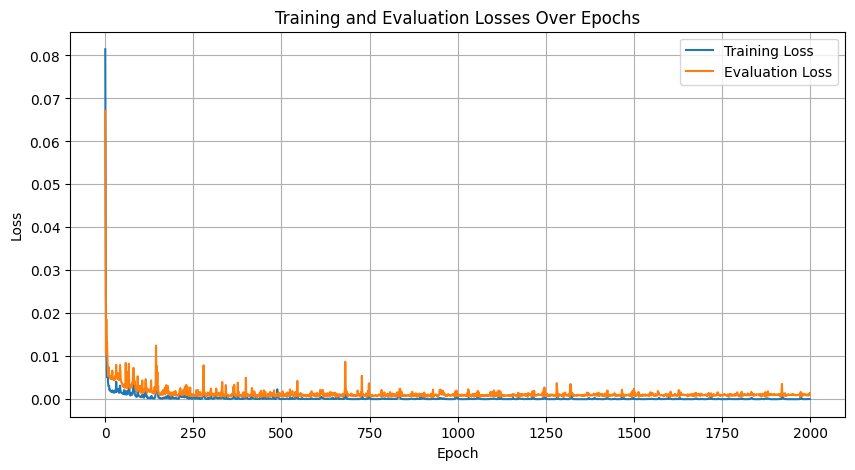

In [21]:
# Plotting the training and evaluation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
save_path =  '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/wing/{}_LSTM_eMO_wingModel_static_lr{}_e{}_nL{}_numNN{}.pth'.format(date, learning_rate, num_epochs, num_layers, hidden_size)
print("The model will be saved as the following:\n {}".format(save_path))

torch.save(model.state_dict(), save_path)

The model will be saved as the following:
 /mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/wing/2025-01-09_LSTM_eMO_wingModel_static_lr0.001_e2000_nL2_numNN50.pth


In [ ]:
joblib.dump(input_scaler, '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/wing/{}_LSTM_eMO_wingModel_static_ipScaler_lr{}_e{}_nL{}_numNN{}.pkl'.format(date, learning_rate, num_epochs, num_layers, hidden_size))
joblib.dump(output_scaler, '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/wing/{}_LSTM_eMO_wingModel_static_opScaler_lr{}_e{}_nL{}_numNN{}.pkl'.format(date, learning_rate, num_epochs, num_layers, hidden_size))


['/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/wing/2025-01-09_LSTM_eMO_wingModel_static_opScaler_lr0.001_e2000_nL2_numNN50.pkl']

: 

naca6412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
[[-2.7557235e-04  4.0651974e-04  1.1451356e-01  6.4721471e-01]]
Input shape: torch.Size([1, 198, 10])
Output shape: torch.Size([1, 198, 2])
naca6412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
[[-2.7557235e-04  4.0651974e-04  1.1451356e-01  6.4721471e-01]]
Input shape: torch.Size([1, 198, 10])
Output shape: torch.Size([1, 198, 2])
naca6412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
[[-2.7557235e-04  4.0651974e-04  1.1451356e-01  6.4721471e-01]]
Input shape: torch.Size([1, 198, 10])
Output shape: torch.Size([1, 198, 2])
naca6412_coordinates.dat
Airfoil Cl NN - Input shape:  (1, 140)
Airfoil Cd NN - Input shape:  (1, 140)
[[-2.7557235e-04  4.0651974e-04  1.1451356e-01  6.4721471e-01]]
Input shape: torch.Size([1, 198, 10])
Output shape: torch.Size([1, 198, 2])
naca6412_coordinates.dat
Air

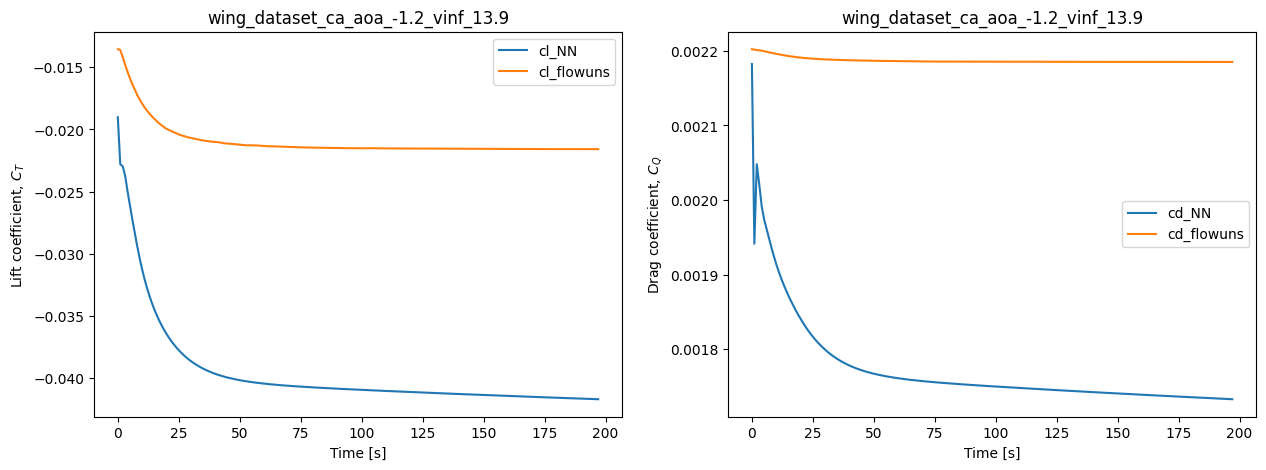

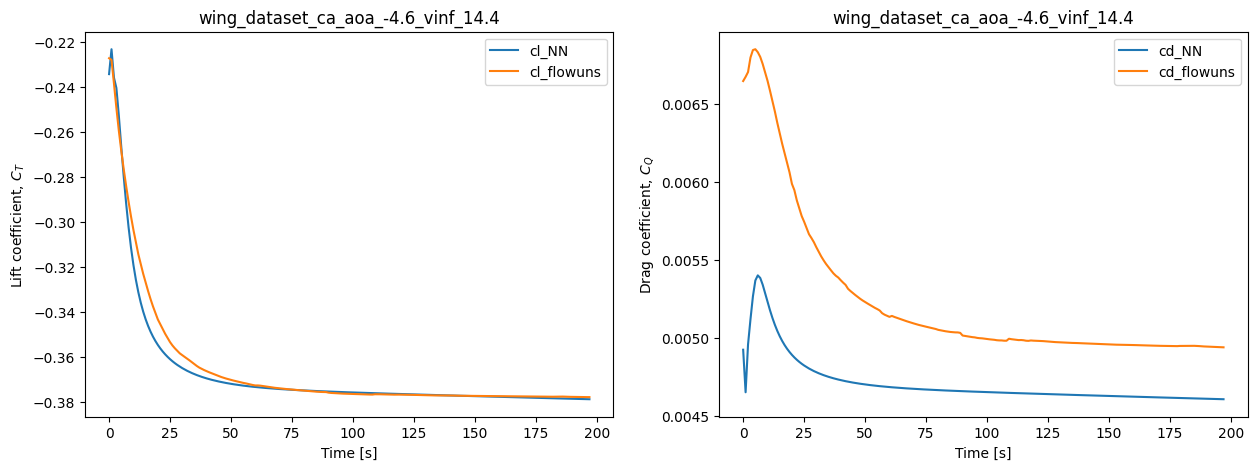

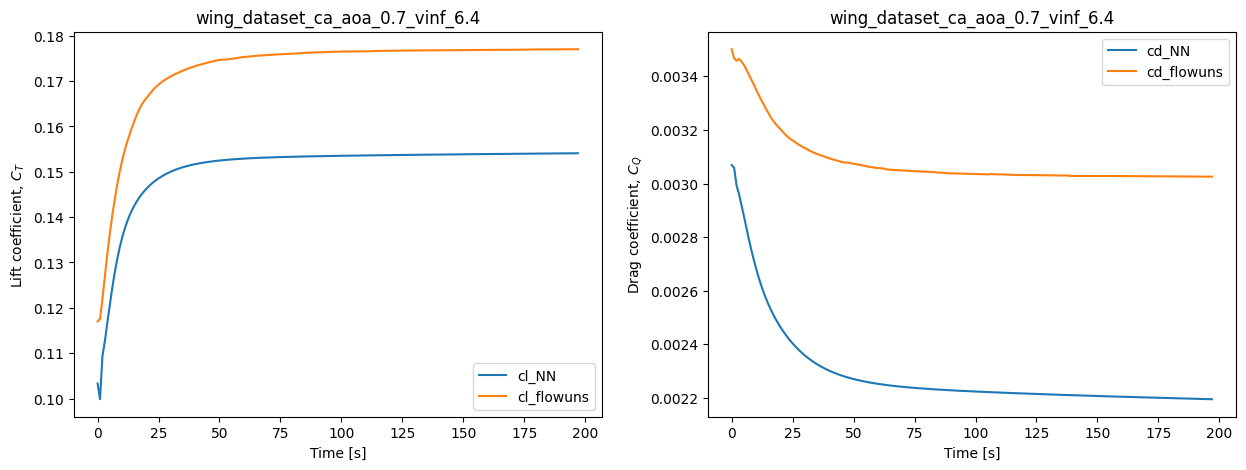

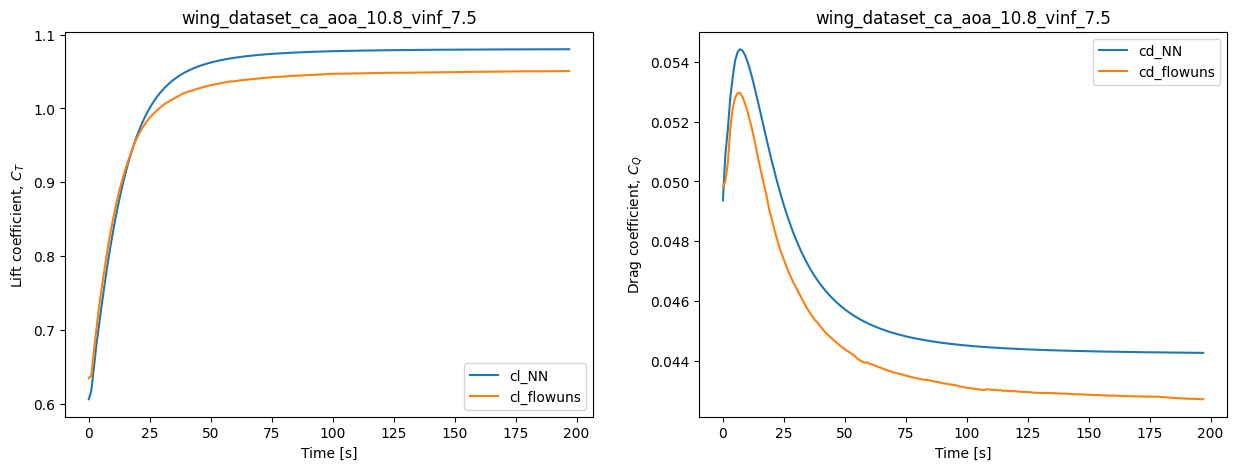

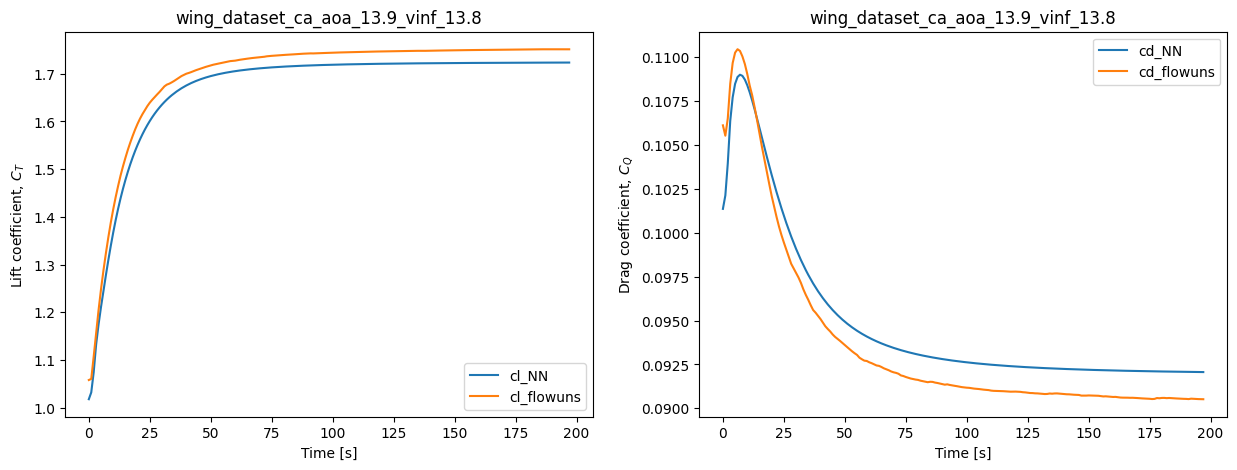

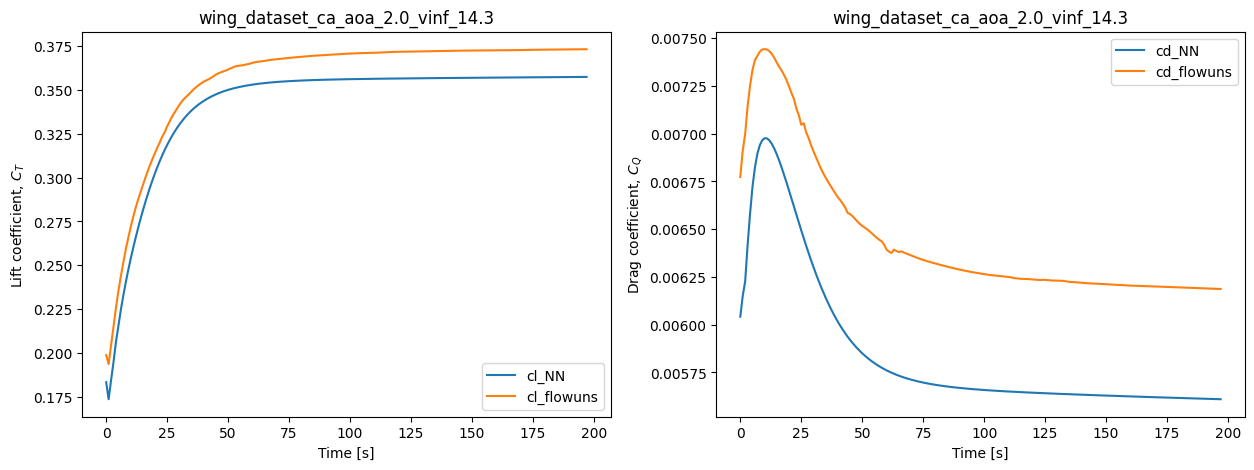

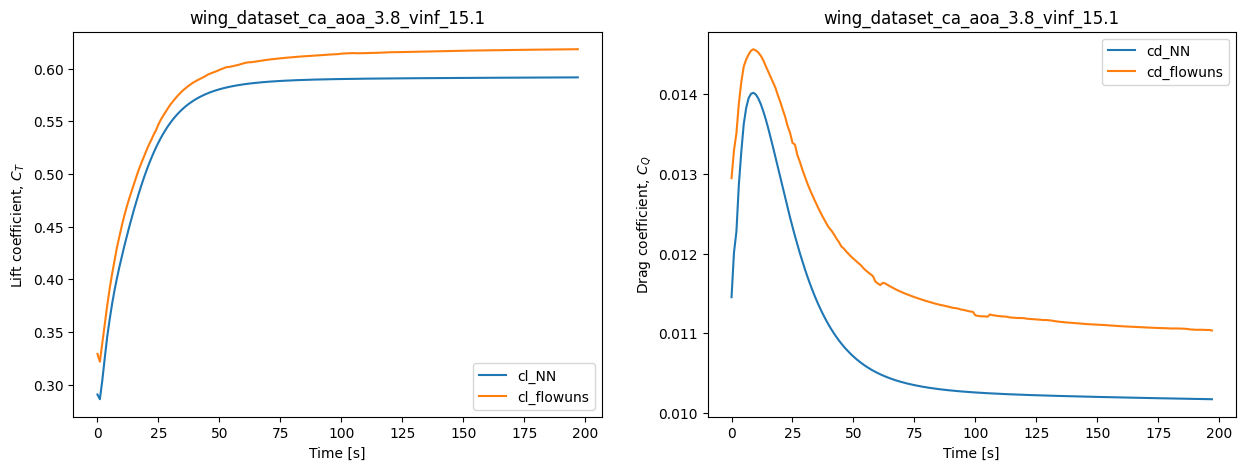

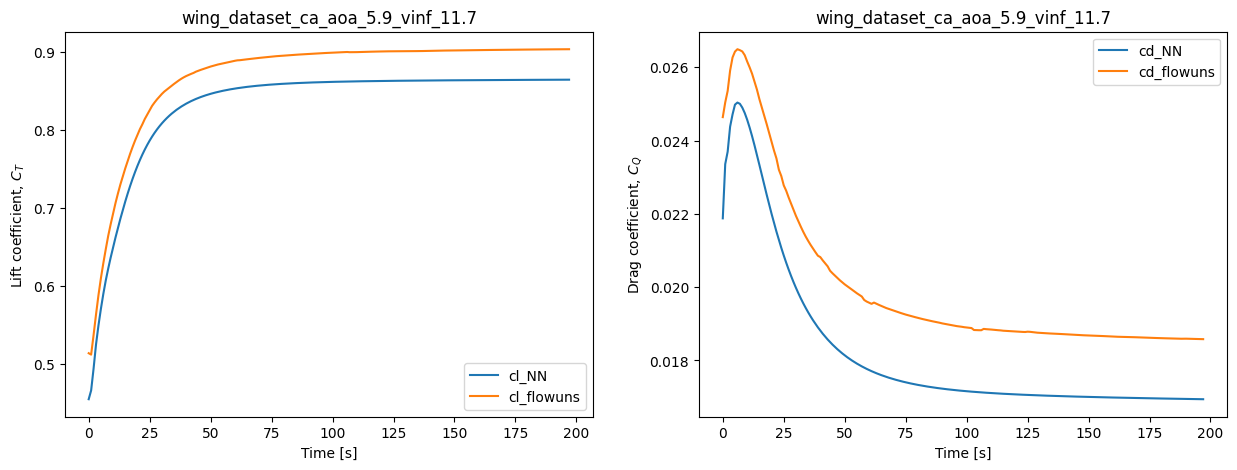

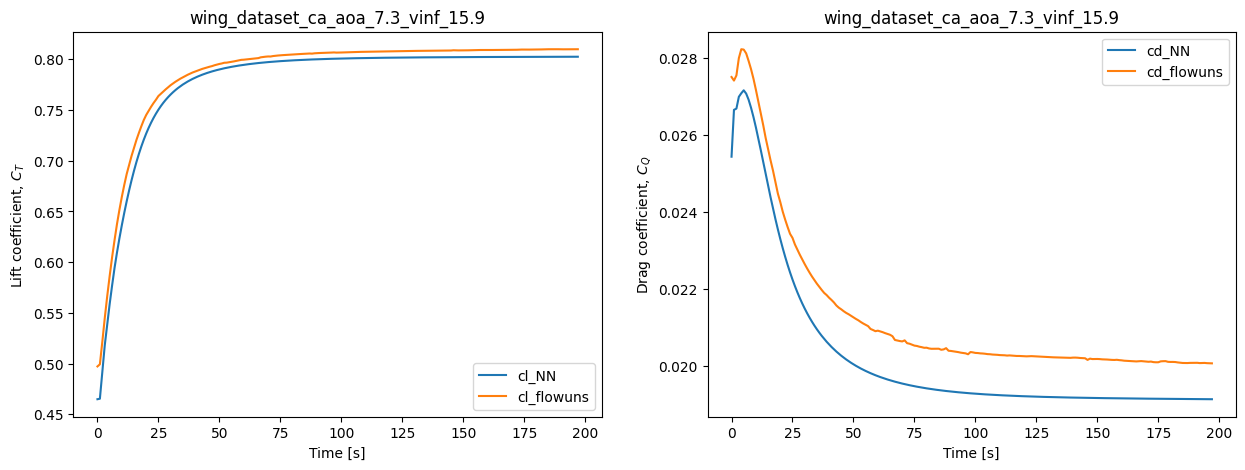

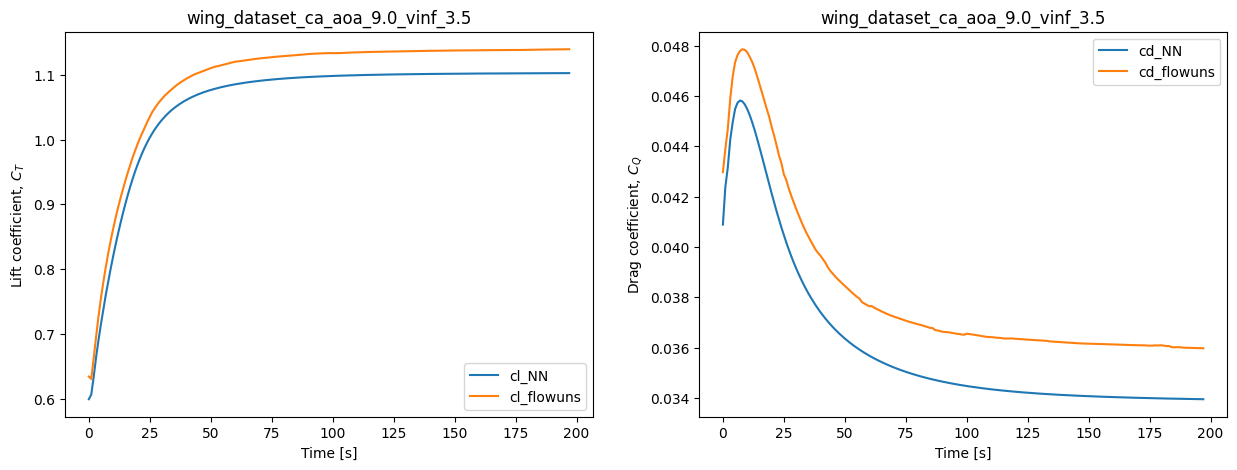

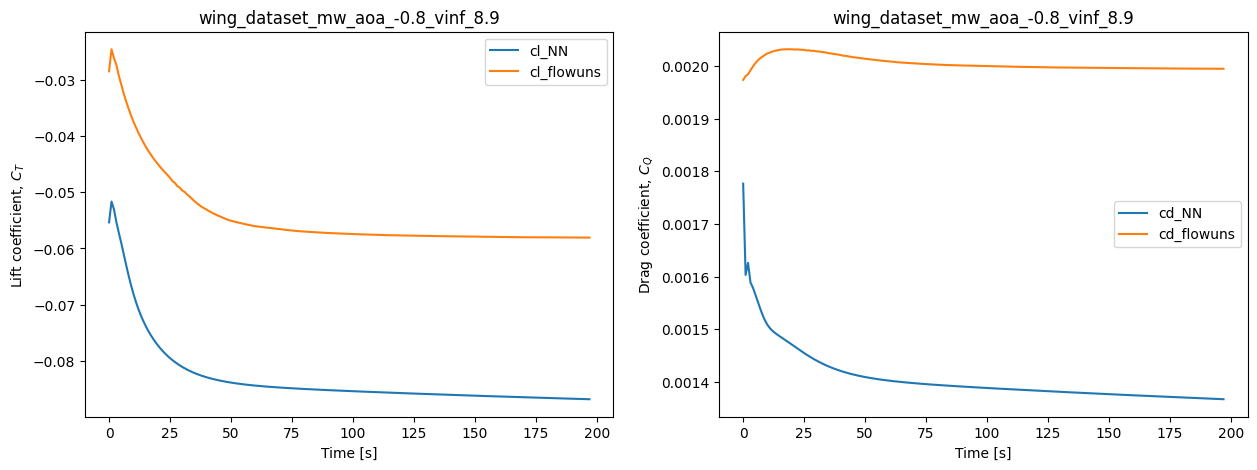

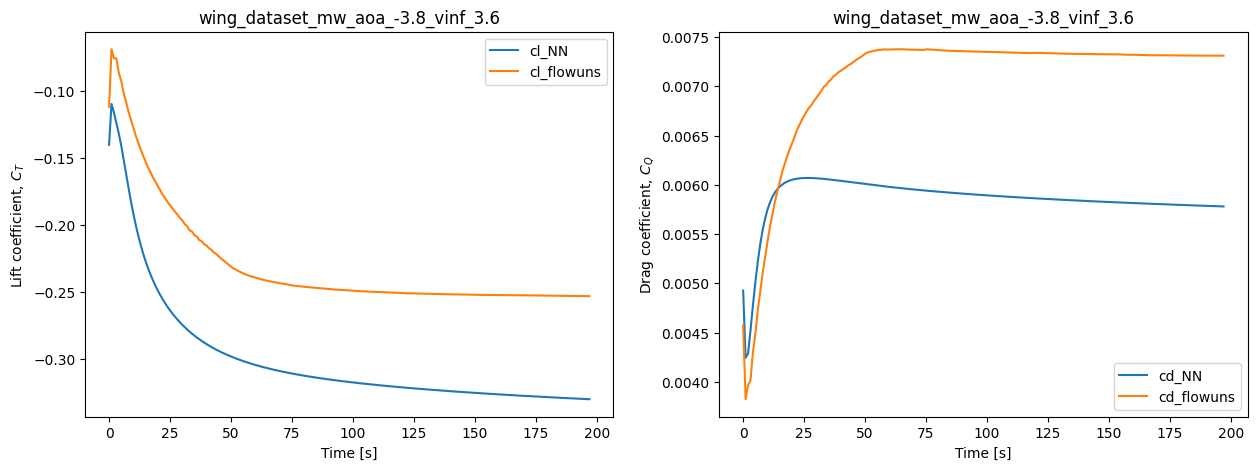

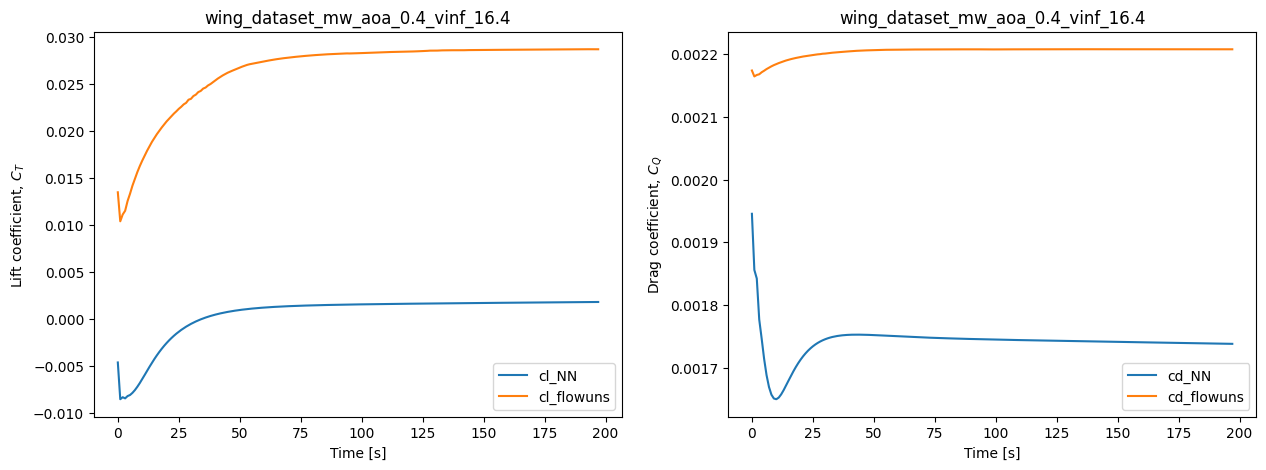

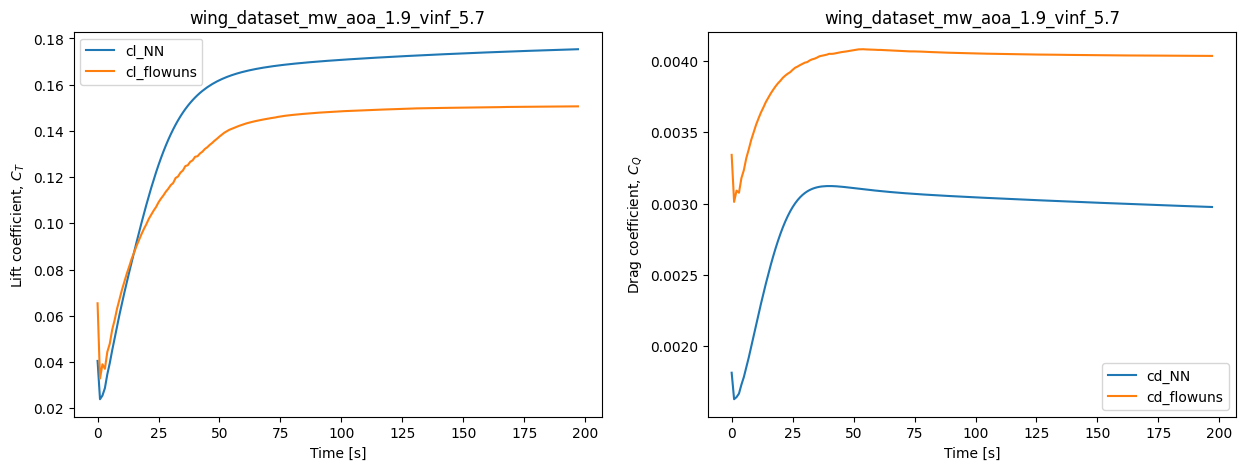

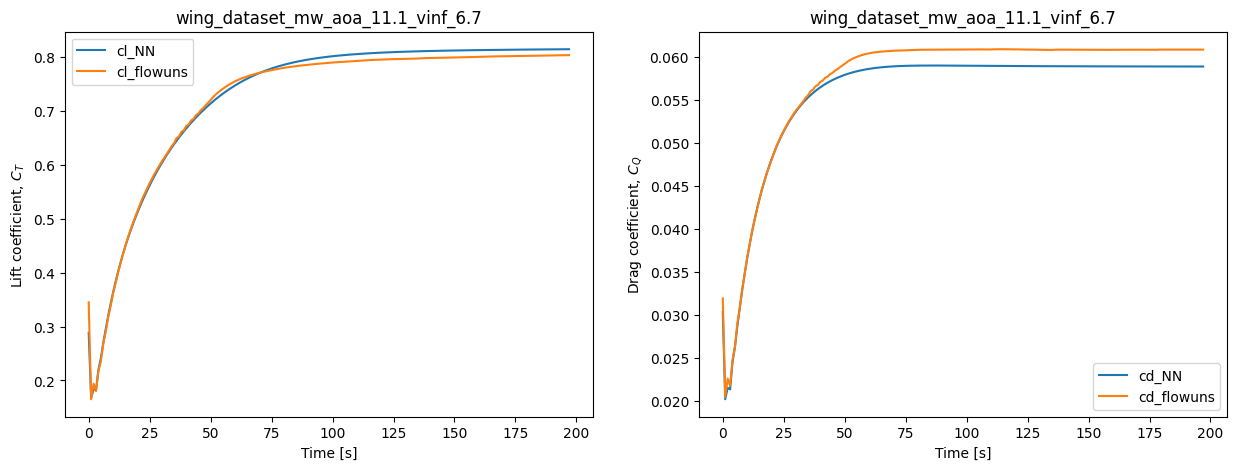

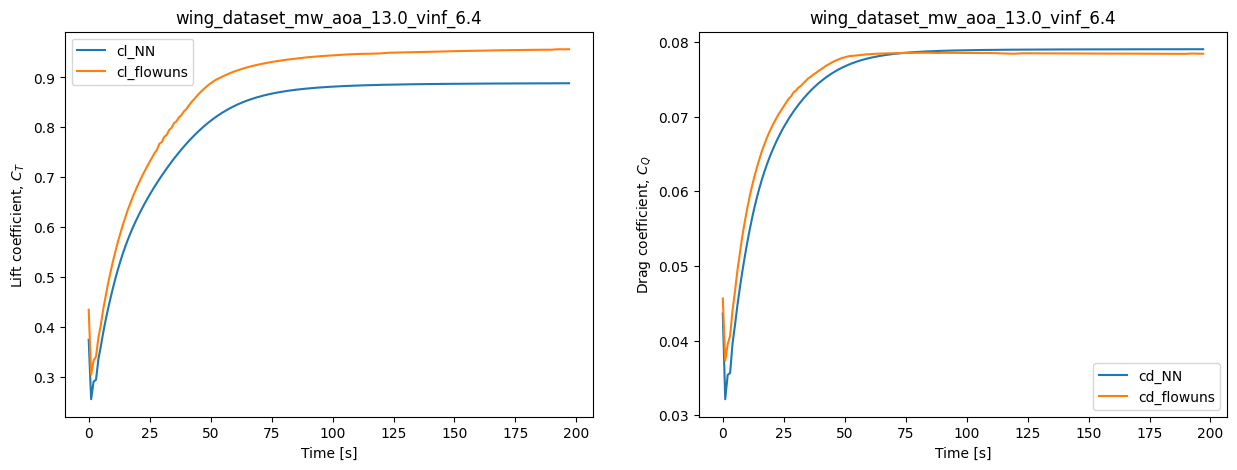

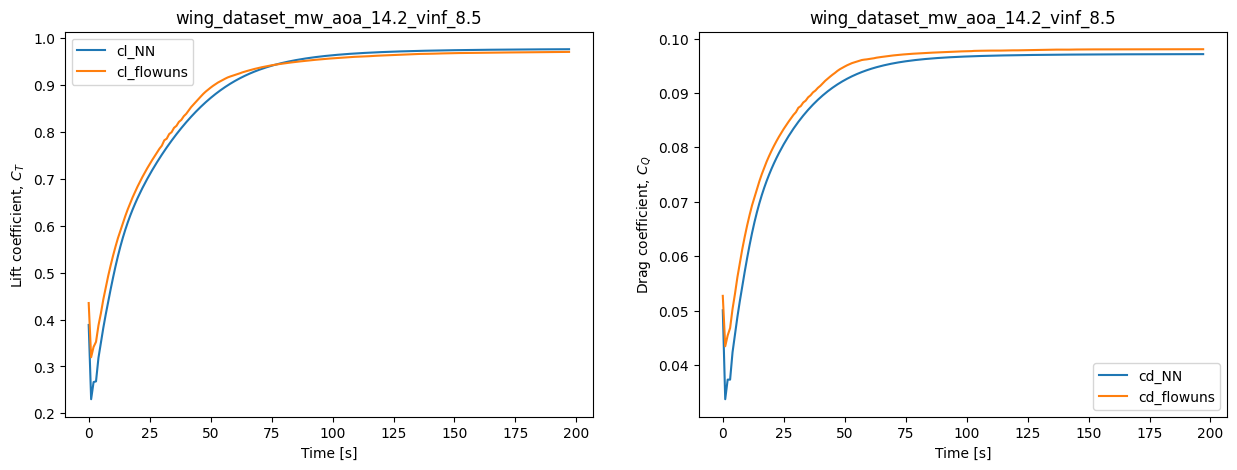

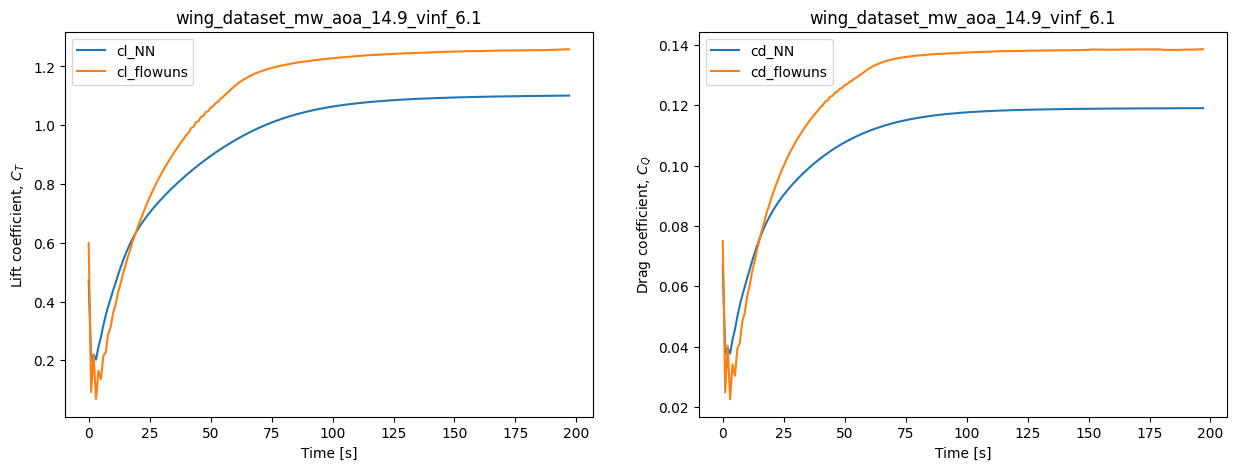

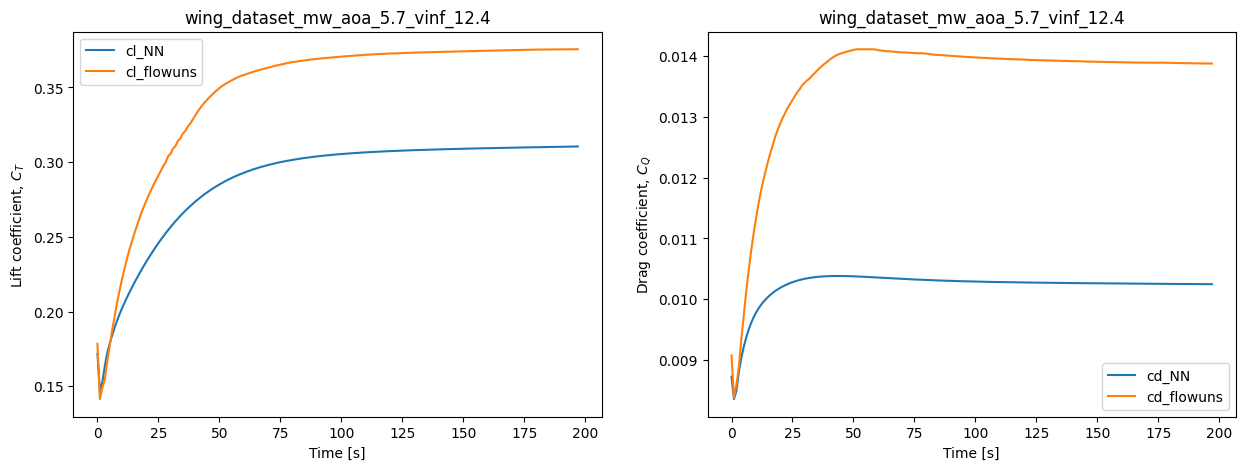

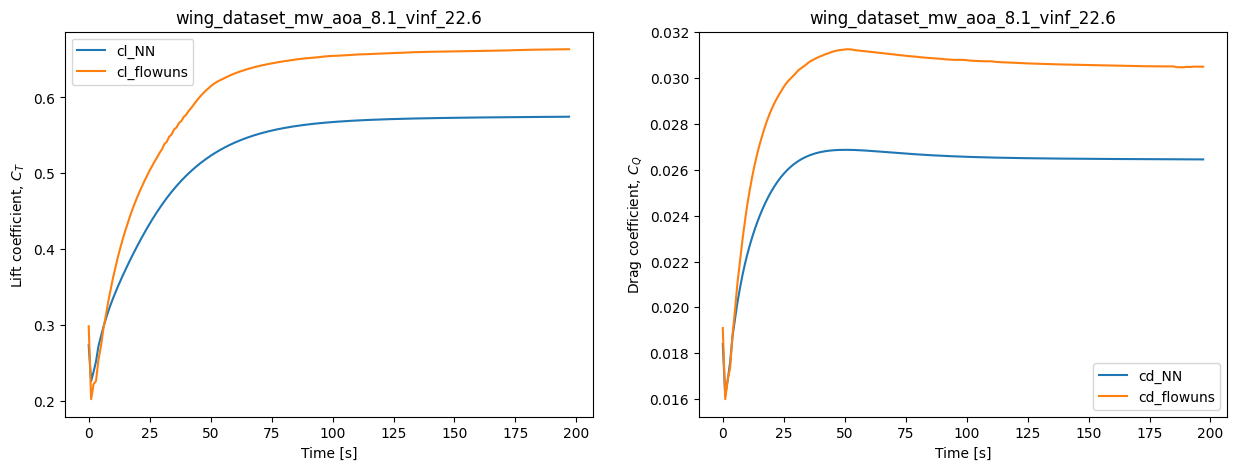

In [24]:
# Root directory where simulation subdirectories are stored
root_test_base = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/FLOWUnsteady_simulations/wing_data/testing_data/'

for simulation_case in os.listdir(root_test_base):
    # Root directory where simulation subdirectories are stored
    root_dir_test_sim = root_test_base+simulation_case
  

    # Create the dataset with a subdirectory condition
    # dataset_test = PropellerDataset(root_dir_test_sim, alpha_test, J_test, theta_test, yaw_test, tilt_test, subdir_condition=subdir_condition)
    dataset_test = WingDataset(root_dir_test_sim, subdir_condition=subdir_condition)
    inputs_test, outputs_test = dataset_test[0:]

    # Assuming your input tensor is named `input_tensor`
    input_tensor_test = inputs_test.squeeze(1)  # Remove the singleton dimension at index 1
    print("Input shape:", input_tensor_test.shape)  # Should print: torch.Size([6, 145, 7])

    output_tensor_test = outputs_test.squeeze(1)
    print("Output shape:",output_tensor_test.shape)

    inputs_test_reshaped = input_tensor_test.reshape(-1, input_size)

    test_inputs_normalized = input_scaler.transform(inputs_test_reshaped.reshape(-1, input_size)).reshape(input_tensor_test.shape)

    test_inputs_tensor = torch.tensor(test_inputs_normalized, dtype=torch.float32).to(device)

    # Make predictions using the trained model
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # predicted_outputs = model(test_inputs_tensor)
        predicted_outputs, attention_weights = model(test_inputs_tensor)


    # Convert the predictions back to numpy and inverse scale the outputs
    predicted_outputs = predicted_outputs.cpu().detach().numpy()  # Convert tensor to numpy array
    predicted_outputs_original_scale = output_scaler.inverse_transform(predicted_outputs.reshape(-1, output_size))

    # Reshape the predictions to match the original sequence structure if needed
    predicted_outputs_original_scale = predicted_outputs_original_scale.reshape(input_tensor_test.shape[0], input_tensor_test.shape[1], output_size)
    predicted_outputs_original_scale = predicted_outputs_original_scale[0]

    # print(predicted_outputs_original_scale.shape)

    # Model predicted values
    # ct_test_NN = predicted_outputs_original_scale[:,0]
    # cq_test_NN = predicted_outputs_original_scale[:,1]

    cl_test_NN = predicted_outputs_original_scale[:,0]
    cd_test_NN = predicted_outputs_original_scale[:,1]
    
    # fft_ct_nn_imag = predicted_outputs_original_scale[:,1]
    # fft_cq_nn_imag = predicted_outputs_original_scale[:,3]

    # Load timesteps, CT and CQ from FLOWUnsteady simualtions
    time_steps = dataset_test.get_variable('time')

    cl_test_flowuns = dataset_test.get_variable('CL')
    cd_test_flowuns = dataset_test.get_variable('CD')

    # fft_ct_fu_real, fft_ct_fu_imag = dataset_test.get_variable('fft_ct')
    # fft_cq_fu_real, fft_cq_fu_imag = dataset_test.get_variable('fft_cq')

    # complex_ct_nn = fft_ct_nn_real +1j * fft_ct_nn_imag
    # ct_test_NN = ifft(complex_ct_nn)

    # complex_cq_nn = fft_cq_nn_real +1j * fft_cq_nn_imag
    # cq_test_NN = ifft(complex_cq_nn)

    # complex_fft_coeff = real_part_nn + 1j * imaginary_part_actual

    

    # Plot the results

    # plt.figure()
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    # plt.plot(time_steps[0], ct_test_NN, label = 'ct_NN')
    # plt.plot(time_steps[0], (ct_test_flowuns[0]), label = 'ct_flowuns')
    plt.plot(cl_test_NN, label = 'cl_NN')
    plt.plot((cl_test_flowuns[0]), label = 'cl_flowuns')
    plt.xlabel('Time [s]')
    plt.ylabel('Lift coefficient, $C_T$')
    plt.title(simulation_case)
    plt.legend()

    # plt.figure()
    plt.subplot(1, 2, 2)
    # plt.plot(time_steps[0], cq_test_NN, label = 'cq_NN')
    # plt.plot(time_steps[0], cq_test_flowuns[0], label = 'cq_flowuns')
    plt.plot(cd_test_NN, label = 'cd_NN')
    plt.plot(cd_test_flowuns[0], label = 'cd_flowuns')
    plt.xlabel('Time [s]')
    plt.ylabel('Drag coefficient, $C_Q$')
    plt.title(simulation_case)
    plt.legend()
